<img style="float: right;" src="https://raw.githubusercontent.com/GridProtectionAlliance/openhistorian-python/main/docs/img/OHPythonAPI_icon32.png">
Install needed packages...

In [2]:
import sys
!"{sys.executable}" -m pip install numpy
!"{sys.executable}" -m pip install openhistorian
!"{sys.executable}" -m pip install plotly-express

<img style="float: right;" src="https://raw.githubusercontent.com/GridProtectionAlliance/openhistorian-python/main/docs/img/OHPythonAPI_icon32.png">
Query some openHistorian data...

In [6]:
from openHistorian.historianConnection import historianConnection
from openHistorian.historianInstance import historianInstance
from openHistorian.historianKey import historianKey
from openHistorian.historianValue import historianValue
from openHistorian.metadataCache import metadataCache
from openHistorian.measurementRecord import SignalType
from snapDB.timestampSeekFilter import timestampSeekFilter
from snapDB.pointIDMatchFilter import pointIDMatchFilter
from typing import Optional, List
from datetime import datetime, timedelta
from time import time
import numpy as np

# Establish lists to hold timestamps and values 
timestamps: List[datetime] = list()
values: List[np.float32] = list()

def readData():
    # Create historian connection (the root API object)
    historian = historianConnection("localhost")
    instance: Optional[historianInstance] = None

    try:
        print("Connecting to openHistorian...")
        historian.Connect()

        if not historian.IsConnected or len(historian.InstanceNames) == 0:
            print("No openHistorian instances detected!")
        else:
            # Get first historian instance
            initialInstance = historian.InstanceNames[0]

            print(f"Opening \"{initialInstance}\" database instance...")
            instance = historian.OpenInstance(initialInstance)

            # Get a reference to the openHistorian metadata cache
            historian.RefreshMetadata()
            metadata = historian.Metadata

            # Lookup measurements that represent frequency values
            records = metadata.GetMeasurementsBySignalType(SignalType.FREQ, instance.Name)
            recordCount = len(records)

            print(f"Queried {recordCount:,} metadata records associated with \"{instance.Name}\" database instance.")

            if recordCount > 0:
                pointIDList = metadataCache.ToPointIDList(records)

                # Execute a test read for ten seconds of data archived ten seconds ago
                endTime = datetime.utcnow() - timedelta(seconds = 10)
                startTime = endTime - timedelta(seconds = 10)

                print(f"Starting read for {len(pointIDList):,} points from {startTime} to {endTime}...\r\n")

                TestRead(instance, historian.Metadata, startTime, endTime, pointIDList)
    except Exception as ex:
        print(f"Failed to connect: {ex}")
    finally:
        if instance is not None:
            instance.Dispose()

        if historian.IsConnected:
            print("Disconnecting from openHistorian")

        historian.Disconnect()

def TestRead(instance: historianInstance, metadata: metadataCache, startTime: datetime, endTime: datetime, pointIDList: List[np.uint64]):
    timeFilter = timestampSeekFilter.CreateFromRange(startTime, endTime)
    pointFilter = pointIDMatchFilter.CreateFromList(pointIDList)

    opStart = time()
    reader = instance.Read(timeFilter, pointFilter)
    count = 0

    key = historianKey()
    value = historianValue()

    while reader.Read(key, value):       
        timestamps.append(key.AsDateTime)
        values.append(value.AsSingle)
        
        if count % 1000 == 0:
            print(f"    Point {key.ToString(metadata)} = {value.ToString()}")
            
        count += 1

    print(f"\r\nRead complete for {count:,} points in {(time() - opStart):.2f} seconds.\r\n")
    
readData()

Connecting to openHistorian...
Opening "PPA" database instance...
Requesting metadata from openHistorian...
Received 13,755 bytes of metadata in 0.07 seconds. Decompressing...
Decompressed 122,727 bytes of metadata in 0.00 seconds. Parsing...
Parsed 252 metadata records in 0.01 seconds.
    Discovered:
        210 measurement records
        1 device records, and
        41 phasor records
Queried 1 metadata records associated with "PPA" database instance.
Starting read for 1 points from 2021-02-15 06:29:31.350035 to 2021-02-15 06:29:41.350035...

    Point 84: NINEMILE_230KV-FQ [FREQ] @ 2021-02-15 06:29:31.366 = 59.993 [QualityFlags.NORMAL]

Read complete for 293 points in 0.02 seconds.

Disconnecting from openHistorian


<img style="float: right;" src="https://raw.githubusercontent.com/GridProtectionAlliance/openhistorian-python/main/docs/img/OHPythonAPI_icon32.png">
Plot queried openHistorian data...

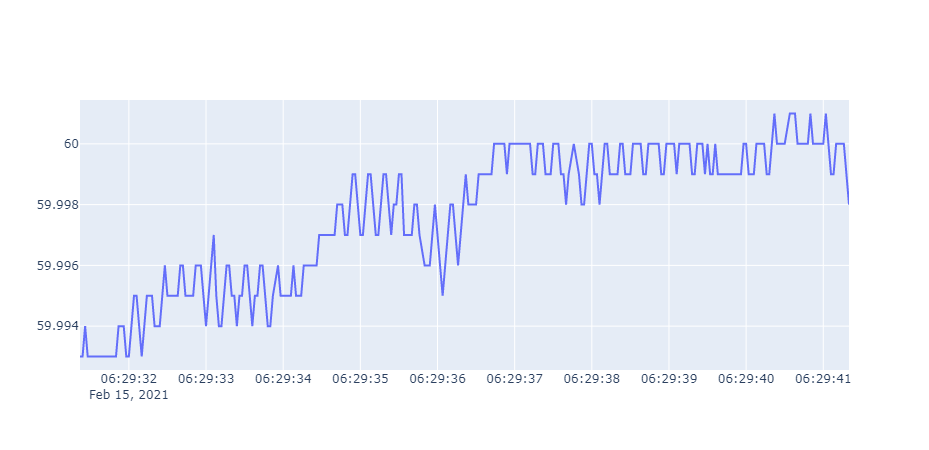

In [7]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter(x=timestamps, y=values))
fig.show()